[View in Colaboratory](https://colab.research.google.com/github/fuulish/colab/blob/master/accumulation_test.ipynb)

Install necessary components

In [40]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


general preparations

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.nn import init

import itertools

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
dtype = torch.FloatTensor

if use_cuda:
    dtype = torch.cuda.FloatTensor

create general model

In [0]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out, bias=None):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H)
        self.fc2 = torch.nn.Linear(H, H)
        self.fc3 = torch.nn.Linear(H, D_out)

        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2))
        init.xavier_uniform(self.fc2.weight, gain=np.sqrt(2))
        init.xavier_uniform(self.fc3.weight, gain=np.sqrt(2))

        if bias is not None:
            init.constant(self.fc3.bias, bias)
            self.fc3.bias.requires_grad = False

        # self.activation = torch.nn.ReLU()
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

prep data

In [0]:
natom = 10
npoint = 10000

x1 = np.random.rand(natom, npoint, 1)
x2 = np.random.rand(natom, npoint, 1)

y = np.sum(np.exp(-x1) + np.sin(x2), axis=0)

# x1 = 2.*(x1 - np.min(x1))/(np.max(x1)-np.min(x1)) - 1
# x2 = 2.*(x2 - np.min(x2))/(np.max(x2)-np.min(x2)) - 1

# x1 = (x1 - x1.mean()) / x1.std()
# x2 = (x2 - x2.mean()) / x2.std()

x1 = torch.autograd.Variable(torch.Tensor(x1).type(dtype))
x2 = torch.autograd.Variable(torch.Tensor(x2).type(dtype))

y = torch.autograd.Variable(torch.Tensor(y).type(dtype))

setup models

In [0]:
models = []
for x in [x1, x2]:
    model = Net(1, 10, 1) #, bias=x.mean())
    if use_cuda:
        model = model.cuda()
    models.append(model)

setup optimizers

In [0]:
parmchain = itertools.chain()

for model in models:
    parmchain = itertools.chain(parmchain, model.parameters())

base_learning_rate = learning_rate = 1.e-1
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, parmchain), lr=learning_rate)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, parmchain), lr=learning_rate)

lambda1 = lambda epoch: 0.999**epoch
lambda1 = lambda epoch: 1.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

loss_func = torch.nn.MSELoss(size_average=True)

nepoch = 1000

def evaluate(models, features):
    y_pred = 0.
    for model, x in zip(models, features):
        y_pred += torch.sum(model(x), dim=0)

    return y_pred

optimize model

In [46]:
for t in range(nepoch):
    y_pred = evaluate(models, [x1, x2])

    optimizer.zero_grad()
    loss = loss_func(y_pred, y)
    loss.backward()

    optimizer.step()
    scheduler.step()

    if t % 10 == 0:
        print(t, loss.data.cpu()[0])

0 117.46773529052734
10 101.51406860351562
20 30.345787048339844
30 1.9121906757354736
40 2.371114730834961
50 1.3869527578353882
60 0.17920561134815216
70 0.16376818716526031
80 0.15135204792022705
90 0.11341886967420578
100 0.09032107889652252
110 0.07859744131565094
120 0.07227551192045212
130 0.06835563480854034
140 0.06527593731880188
150 0.06228544935584068
160 0.05931776762008667
170 0.05645168945193291
180 0.05364321917295456
190 0.05089811608195305
200 0.04822598397731781
210 0.04563141614198685
220 0.0431201197206974
230 0.040696144104003906
240 0.038362544029951096
250 0.03612156957387924
260 0.03397460654377937
270 0.03192225471138954
280 0.029964447021484375
290 0.028100550174713135
300 0.026329373940825462
310 0.024649281054735184
320 0.023058287799358368
330 0.021554088220000267
340 0.020134111866354942
350 0.018795600160956383
360 0.01753564551472664
370 0.016351211816072464
380 0.015239227563142776
390 0.014196556061506271
400 0.013220039196312428
410 0.012306564487516

plot results

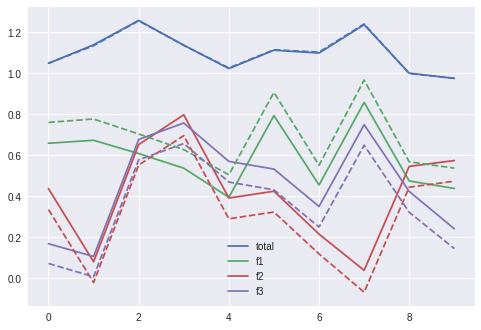

In [47]:
stride = 1000

p1 = plt.plot(y.data.cpu().numpy()[::stride] / natom, label='total')
p2 = plt.plot(np.exp(-x1[0].data.cpu().numpy().sum(axis=1))[::stride], label='f1')
p3 = plt.plot(np.sin(x2[0].data.cpu().numpy().sum(axis=1))[::stride], label='f2')
p4 = plt.plot(np.sin(x2[1].data.cpu().numpy().sum(axis=1))[::stride], label='f3')

plt.plot(evaluate(models, [x1,x2]).data.cpu().numpy()[::stride] / natom, '--', color=p1[0].get_color())
plt.plot(models[0](x1[0]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p2[0].get_color())
plt.plot(models[1](x2[0]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p3[0].get_color())
plt.plot(models[1](x2[1]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p4[0].get_color())

plt.legend()

plt.show()